# Imports

In [24]:
import pyxdf
import pandas as pd
import numpy as np
import sounddevice as sd
from glob import glob
from tqdm import tqdm
import librosa
import datetime
import re
import matplotlib.pyplot as plt

# Load Data

In [25]:
sub_files = glob('../*/*.xdf')
sub_files

['../sub-P5318014/sub-P5318014_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../sub-5182010/sub-P5182010_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../sub-P5447527/sub-P5447527_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../sub-5958030/sub-P5958030_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../sub-P5899288/sub-P5899288_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../sub-P5548165/sub-P5548165_ses-S001_task-CUNY_run-001_MOBI.xdf']

In [26]:
xdf_path = sub_files[0]
data, header = pyxdf.load_xdf(xdf_path)
streams_collected = [stream['info']['name'][0] for stream in data]

'''
HELPERS
'''
def get_event_data(event, df, stim_df):
    return df.loc[(df.lsl_time_stamp >= stim_df.loc[stim_df.event == 'Onset_'+event, 'lsl_time_stamp'].values[0]) & 
                  (df.lsl_time_stamp <= stim_df.loc[stim_df.event == 'Offset_'+event, 'lsl_time_stamp'].values[0])]

def get_secs_between_triggers(trigger1, trigger2, stim_df):
    return stim_df.loc[stim_df.trigger == trigger1, 'time'].values[0] - stim_df.loc[stim_df.trigger == trigger2, 'time'].values[0]
      
streams_collected

KeyboardInterrupt: 

# Stimulus

In [5]:
stim_dat = data[streams_collected.index('Stimuli_Markers')]
stim_df = pd.DataFrame(stim_dat['time_series'])
stim_df.rename(columns={0: 'trigger'}, inplace=True)
events = {
    200: 'Onset_Experiment',
    10: 'Onset_RestingState',
    11: 'Offset_RestingState',
    500: 'Onset_StoryListening',
    501: 'Offset_StoryListening',
    100: 'Onset_10second_rest',
    101: 'Offset_10second_rest', 
    20: 'Onset_CampFriend',
    21: 'Offset_CampFriend',
    30: 'Onset_FrogDissection',
    31: 'Offset_FrogDissection',
    40: 'Onset_DanceContest',
    41: 'Offset_DanceContest',
    50: 'Onset_ZoomClass',
    51: 'Offset_ZoomClass',
    60: 'Onset_Tornado',
    61: 'Offset_Tornado',
    70: 'Onset_BirthdayParty',
    71: 'Offset_BirthdayParty',
    300: 'Onset_subjectInput',
    301: 'Offset_subjectInput',
    302: 'Onset_FavoriteStory',
    303: 'Offset_FavoriteStory',
    304: 'Onset_WorstStory',
    305: 'Offset_WorstStory',
    400: 'Onset_impedanceCheck',
    401: 'Offset_impedanceCheck',
    80: 'Onset_SocialTask',
    81: 'Offset_SocialTask',
    201: 'Offset_Experiment',
}

story_onsets = [20, 30, 40, 50, 60, 70]

# relabel the event if the trigger is in the events dictionary, else if 
stim_df['event'] = stim_df['trigger'].apply(lambda x: events[x] if x in events.keys() else 'Bx_input')

# relabel the event as a psychopy timestamp if the trigger is greater than 5 digits
stim_df.loc[stim_df.trigger.astype(str).str.len() > 5, 'event'] = 'psychopy_time_stamp'
stim_df['lsl_time_stamp'] = stim_dat['time_stamps']
stim_df['time'] = (stim_dat['time_stamps'] - stim_dat['time_stamps'][0])/1000
stim_df

,trigger,event,lsl_time_stamp,time
0,200,Onset_Experiment,737702.874688,0.000000e+00
1,1729193598,psychopy_time_stamp,737702.874699,1.029996e-08
2,10,Onset_RestingState,737715.257669,1.238298e-02
3,1729193610,psychopy_time_stamp,737715.257678,1.238299e-02
4,11,Offset_RestingState,738015.257488,3.123828e-01
...,...,...,...,...
256,1729195883,psychopy_time_stamp,739988.698994,2.285824e+00
257,201,Offset_Experiment,739993.702234,2.290828e+00
258,1729195888,psychopy_time_stamp,739993.702247,2.290828e+00
259,4,Bx_input,739993.702478,2.290828e+00


# Microphone Data 

In [6]:
mic_data = data[streams_collected.index('Microphone')]
mic_df = pd.DataFrame(mic_data['time_series'], columns=['int_array'])
mic_df['bytestring'] = mic_df['int_array'].apply(lambda x: np.array(x).tobytes())
mic_df['time_stamps'] = (mic_data['time_stamps'] - mic_data['time_stamps'][0])/441000

mic_df['lsl_time_stamp'] = mic_data['time_stamps']
mic_df['time'] = (mic_df.lsl_time_stamp - mic_df.lsl_time_stamp[0])
mic_df['time_delta'] = mic_df['lsl_time_stamp'].diff()

mic_df.tail()

,int_array,bytestring,time_stamps,lsl_time_stamp,time,time_delta
87732536,31,b'\x1f\x00\x00\x00\x00\x00\x00\x00',0.004511,740040.097456,1989.483575,0.000023
87732537,30,b'\x1e\x00\x00\x00\x00\x00\x00\x00',0.004511,740040.097479,1989.483598,0.000023
87732538,26,b'\x1a\x00\x00\x00\x00\x00\x00\x00',0.004511,740040.097501,1989.483621,0.000023
87732539,26,b'\x1a\x00\x00\x00\x00\x00\x00\x00',0.004511,740040.097524,1989.483643,0.000023
87732540,-37,b'\xdb\xff\xff\xff\xff\xff\xff\xff',0.004511,740040.097547,1989.483666,0.000023


## Compare wav and LSL lengths

In [7]:
# get wav file
wav_files = glob('../*/*.wav')
wav_path = wav_files[0]

In [8]:
# calculate wav and lsl durations
wav_dur = round(librosa.get_duration(path=wav_path), 2)
lsl_dur = round(mic_df['lsl_time_stamp'].iloc[-1]- mic_df['lsl_time_stamp'].iloc[0], 2)

# convert to hh:mm:ss
wav_dt = datetime.timedelta(seconds=wav_dur)
wav_dur_dt = str(datetime.timedelta(seconds=round(wav_dt.total_seconds())))
lsl_dt = datetime.timedelta(seconds=lsl_dur)
lsl_dur_dt = str(datetime.timedelta(seconds=round(lsl_dt.total_seconds())))

# make df of durations
variables = {name: [globals()[name], globals()[name+'_dt']]  for name in ['wav_dur', 'lsl_dur']}
durations_df = pd.DataFrame.from_dict(variables, orient = 'index', columns = ['seconds', 'mm:ss'])
print(durations_df.to_string() + '\n')

# print if they are close or not (margin on 5 seconds rn)
if abs(wav_dur - lsl_dur) > 5:
    print(f'Warning: The duration of the wav file ({wav_dur}) and the duration of the lsl time stamps ({lsl_dur}) differ by more than 5 seconds. \n')
    if wav_dur > lsl_dur:
        print('The wav file is longer than the lsl time stamps by {} seconds'.format(wav_dur - lsl_dur))
    if lsl_dur > wav_dur:
        print('The lsl time stamps are longer than the wav file by {} seconds'.format(lsl_dur - wav_dur))
else: 
    print('The wav file and the lsl time stamps are the same length!')

         seconds    mm:ss
wav_dur  1989.40  0:33:09
lsl_dur  1989.48  0:33:09

The wav file and the lsl time stamps are the same length!


## Graph, Stats, Sampling Rate


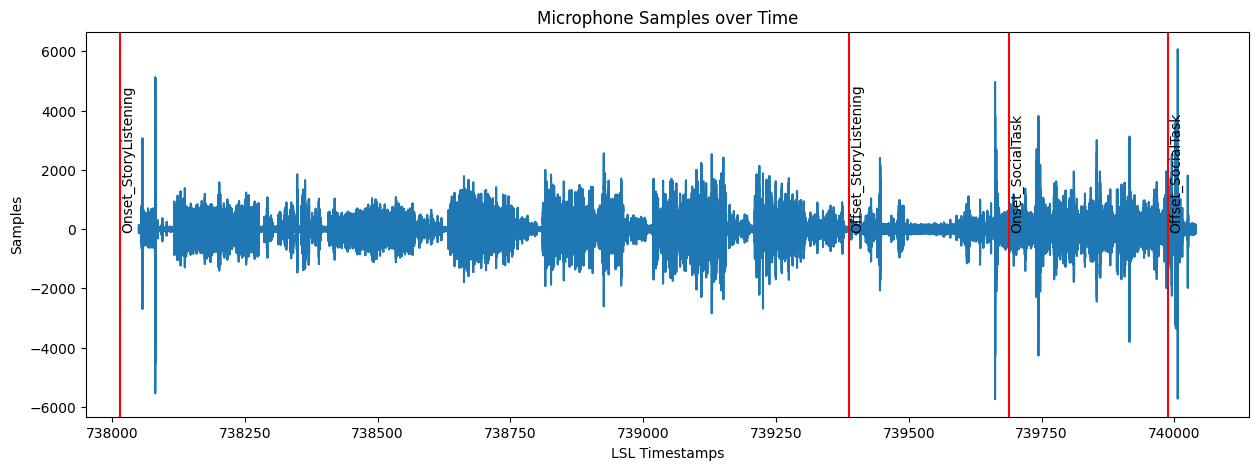

In [9]:
# plot samples 
plt.figure(figsize=(15, 5))
plt.plot(mic_df.lsl_time_stamp, mic_df.int_array)
for event in stim_df.loc[stim_df.event.str.contains('StoryListening|SocialTask')].iterrows():
    plt.axvline(event[1]['lsl_time_stamp'], color='r')
    plt.text(event[1]['lsl_time_stamp']+2, 0, event[1]['event'], rotation=90)

plt.xlabel('LSL Timestamps')
plt.ylabel('Samples')
plt.title('Microphone Samples over Time')
plt.show()

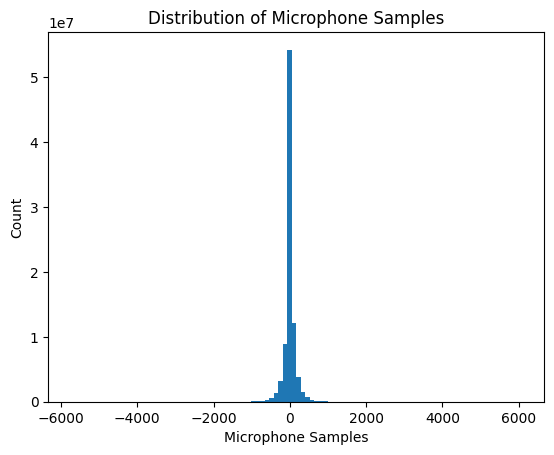

In [10]:
# hist of samples
plt.hist(mic_df['int_array'], bins=100)
plt.xlabel('Microphone Samples')
plt.ylabel('Count')
plt.title('Distribution of Microphone Samples')
plt.show()

# looking to make sure it's relatively centered around 0, no outlier peaks, no values above 32k or below -32k

### Stats that might not be included


In [11]:
# 25% and 75% quantiles
quan25 = np.quantile(mic_df['int_array'], 0.25)
quan75 = np.quantile(mic_df['int_array'], 0.75)

if quan75 - quan25 > 100:
    print('range is really large??')
print('first quartile: {} \nsecond quartile: {}'.format(quan25, quan75))

# standard dev
print("standard deviation: {:.4f}".format(mic_df['int_array'].std()))

# range, should be between -32768 and 32767
print("min: ", min(mic_df.int_array), "\nmax: ", max(mic_df.int_array))

first quartile: -37.0 
second quartile: 37.0
standard deviation: 157.3225
min:  -5742 
max:  6073


In [12]:
# no of NA's
print("number of NaN's: ", mic_df['int_array'].isna().sum())

number of NaN's:  0


## Sampling Rate

In [13]:
nom_srate = float(mic_data['info']['nominal_srate'][0])
eff_srate = mic_data['info']['effective_srate']
srate_diff = 44100.00 - eff_srate

if nom_srate != 44100.0:
    print(f"Alert! Nominal sampling rate is not 44.1 kHz! It is {nom_srate}")
if abs(srate_diff) > 5: # 5?
    print(f'Alert! Effective sampling rate is not 44.1 kHz! It is {eff_srate} Hz, {srate_diff} Hz away from 44.1kHz')

print(f'nominal sampling rate: {nom_srate}\neffective sampling rate: {eff_srate:.4f}')


nominal sampling rate: 44100.0
effective sampling rate: 44098.1454


# Eye Tracking

In [14]:
# et_df-- all eye tracking data
ET = data[streams_collected.index('Tobii')]
et_dat = ET['time_series']
# Get the column names
column_labels = [ET['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(len(ET['info']['desc'][0]['channels'][0]['channel']))]

et_df = pd.DataFrame(data=et_dat, columns=column_labels)
et_df['lsl_time_stamp'] = ET['time_stamps']
et_df['time'] = (ET['time_stamps'] - ET['time_stamps'][0])/1000
et_df

,device_time_stamp,left_gaze_origin_validity,right_gaze_origin_validity,left_gaze_origin_in_user_coordinate_system_0,left_gaze_origin_in_user_coordinate_system_1,left_gaze_origin_in_user_coordinate_system_2,right_gaze_origin_in_user_coordinate_system_0,right_gaze_origin_in_user_coordinate_system_1,right_gaze_origin_in_user_coordinate_system_2,left_gaze_origin_in_trackbox_coordinate_system_0,...,left_gaze_point_on_display_area_0,left_gaze_point_on_display_area_1,right_gaze_point_on_display_area_0,right_gaze_point_on_display_area_1,left_pupil_validity,right_pupil_validity,left_pupil_diameter,right_pupil_diameter,lsl_time_stamp,time
0,1.752509e+12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,737627.304371,0.000000
1,1.752509e+12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,737627.312704,0.000008
2,1.752509e+12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,737627.321038,0.000017
3,1.752509e+12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,737627.329372,0.000025
4,1.752509e+12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,737627.337705,0.000033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170392,1.754949e+12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,740067.977859,2.440673
170393,1.754949e+12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,740067.986193,2.440682
170394,1.754949e+12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,740067.994527,2.440690
170395,1.754949e+12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,740068.002860,2.440698


In [15]:
# val_df-- percent valid from each validity column
val_cols = et_df.filter(like = 'validity').columns
val_df = pd.DataFrame(columns = ['variable', 'percent_valid'])
val_df['variable'] = val_cols

for i, var in enumerate(val_cols):
    val_df.loc[i, 'percent_valid'] = round(np.mean(et_df[var]), 4)

val_df

,variable,percent_valid
0,left_gaze_origin_validity,0.6011
1,right_gaze_origin_validity,0.538
2,left_gaze_point_validity,0.601
3,right_gaze_point_validity,0.5378
4,left_pupil_validity,0.601
5,right_pupil_validity,0.5378


## Compare valid data between left and right eyes

In [21]:
# get % validity for left and right eyes
left = val_df[val_df.variable.str.startswith('left')]
right = val_df[val_df.variable.str.startswith('right')]

RL_val = pd.DataFrame(columns = ['eye','min', 'max', 'mean'])

for i, (df, RL) in enumerate([(left, 'left'), (right, 'right')]):
    min1 = min(df['percent_valid'])
    max1 = max(df['percent_valid'])
    mean1 = round(np.mean(df['percent_valid']), 4)
    RL_val.loc[i] = [RL, min1, max1, mean1]


RL_val

,eye,min,max,mean
0,left,0.6010,0.6011,0.6010
1,right,0.5378,0.5380,0.5379


In [22]:
# find diff between RL 
RL_val.loc[2] = ['diff', RL_val['min'].diff()[1], RL_val['max'].diff()[1], RL_val['mean'].diff()[1]]

# add blank row 
blank = pd.DataFrame([['', '', '', '']], columns = RL_val.columns)
RL_val = pd.concat([RL_val.iloc[:2], blank, RL_val.iloc[2:]])
RL_val.reset_index(drop=True, inplace=True)
RL_val


,eye,min,max,mean
0,left,0.601,0.6011,0.601
1,right,0.5378,0.538,0.5379
2,,,,
3,diff,-0.0632,-0.0631,-0.0631


In [23]:
lmean = RL_val.loc[RL_val.eye =='left', 'mean'][0]
rmean = RL_val.loc[RL_val.eye =='right', 'mean'][1]
mean_diff = RL_val.loc[RL_val.eye =='diff', 'mean'][3]

print('mean validity for left eye is {:.2%}.\n\
mean validity for right eye is {:.2%}.\n\
the difference is {:.2%}.'.format(lmean, rmean, abs(mean_diff)))

mean validity for left eye is 60.10%.
mean validity for right eye is 53.79%.
the difference is 6.31%.
